<a href="https://colab.research.google.com/github/AvinashBisram/CUS754_Spring2024/blob/main/ResearchProject/Using_Images_to_Improve_Prediction_of_Anime_Ratings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Images to Improve Prediction of Anime Ratings

**Goal**: The overarching goal of this project is to use Machine Learning to predict the ratings of popular Anime shows/movies. A model will be trained on tabular data relating to each show gathered from MyAnimeList and combined with a CNN trained on promotional images of the show to see if there is any improvement and what is the best model we can create.

**Intuition**: Information about the plot, themes, and genre of a show may do well in predicting the popularity however, animation and art style are definitely aspects of shows that can add a lot of value or detract from the overall experience. We want to see if a CNN trained on images from popular shows can add any value to a traditional ML model to extract some of that "signal" that viewers experience when watching.

In [1]:
# Importing Necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from io import BytesIO
import os

from IPython.display import clear_output

# import skimage.io as im
import sklearn as sk
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

import spacy
from scipy import stats

# ChatGPT potential solution for image loading
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import Sequence

import tensorflow
from tensorflow.keras import backend
import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, MaxPool3D, AveragePooling2D, AveragePooling3D, BatchNormalization, Activation, Flatten

import random
random.seed(101) # For reproducibility

## Loading the Data

As mentioned in the accompanying "Data Collection" notebook, the output of that process was saved on Kaggle. This notebook will utilize that data instead of the local copies to allow for reproducibility.

In [2]:
# From Kaggle

from google.colab import userdata

# Data is stored privately so I use my Kaggle API Credentials stored in Google Colab "Secrets"
#os.environ['KAGGLE_USERNAME'] = userdata.get('KaggleUsername')
#os.environ['KAGGLE_KEY'] = userdata.get('KagglePassword')

In [3]:
# Downloading the data from Kaggle

!kaggle datasets download -d avinashbisram/animeratingprediction

Dataset URL: https://www.kaggle.com/datasets/avinashbisram/animeratingprediction
License(s): unknown
 96% 328M/341M [00:03<00:00, 137MB/s]
100% 341M/341M [00:03<00:00, 109MB/s]


In [4]:
# Unzipping the Kaggle files

!unzip animeratingprediction.zip

clear_output()
print("Data Downloaded.")

Data Downloaded.


In [5]:
# Loading the two tabular datasets

anime_data_raw = pd.read_csv('anime_data.csv')
anime_data_raw.info()
anime_data_raw.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1867 entries, 0 to 1866
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1867 non-null   int64  
 1   Name         1867 non-null   object 
 2   Link         1867 non-null   object 
 3   Score        1867 non-null   float64
 4   Blurb        1867 non-null   object 
 5   Type         1867 non-null   object 
 6   Episodes     1867 non-null   object 
 7   Status       1867 non-null   object 
 8   Producers    1867 non-null   object 
 9   Studios      1867 non-null   object 
 10  Source       1867 non-null   object 
 11  Genre        1425 non-null   object 
 12  Demographic  922 non-null    object 
 13  Duration     1867 non-null   object 
 14  Rating       1867 non-null   object 
dtypes: float64(1), int64(1), object(13)
memory usage: 218.9+ KB


,Unnamed: 0,Name,Link,Score,Blurb,Type,Episodes,Status,Producers,Studios,Source,Genre,Demographic,Duration,Rating
0,0,Sousou no Frieren,https://myanimelist.net/anime/52991/Sousou_no_...,9.39,During their decade-long quest to defeat the D...,TV,28,Finished Airing,"Aniplex, Dentsu, Shogakukan-Shueisha Productio...",Madhouse,Manga,"AdventureAdventure,DramaDrama,FantasyFantasy",ShounenShounen,24 min. per ep.,PG-13 - Teens 13 or older
1,1,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_A...,9.09,After a horrific alchemy experiment goes wrong...,TV,64,Finished Airing,"Aniplex, Square Enix, Mainichi Broadcasting Sy...",Bones,Manga,"ActionAction,AdventureAdventure,DramaDrama,Fan...",ShounenShounen,24 min. per ep.,R - 17+ (violence & profanity)
2,2,Steins;Gate,https://myanimelist.net/anime/9253/Steins_Gate,9.07,Eccentric scientist Rintarou Okabe has a never...,TV,24,Finished Airing,"Frontier Works, Media Factory, Kadokawa Shoten...",White Fox,Visual novel,"DramaDrama,Sci-FiSci-Fi,SuspenseSuspense",NaN,24 min. per ep.,PG-13 - Teens 13 or older
3,3,Gintama°,https://myanimelist.net/anime/28977/Gintama°,9.06,"Gintoki, Shinpachi, and Kagura return as the f...",TV,51,Finished Airing,"TV Tokyo, Aniplex, Dentsu",Bandai Namco Pictures,Manga,"ActionAction,ComedyComedy,Sci-FiSci-Fi",ShounenShounen,24 min. per ep.,PG-13 - Teens 13 or older
4,4,Shingeki no Kyojin Season 3 Part 2,https://myanimelist.net/anime/38524/Shingeki_n...,9.05,Seeking to restore humanity's diminishing hope...,TV,10,Finished Airing,"Production I.G, Dentsu, Mainichi Broadcasting ...",Wit Studio,Manga,"ActionAction,DramaDrama,SuspenseSuspense",ShounenShounen,23 min. per ep.,R - 17+ (violence & profanity)
5,5,Gintama: The Final,https://myanimelist.net/anime/39486/Gintama__T...,9.04,Two years have passed following the Tendoshuu'...,Movie,1,Finished Airing,"TV Tokyo, Aniplex, Dentsu, Bandai, Warner Bros...",Bandai Namco Pictures,Manga,"ActionAction,ComedyComedy,DramaDrama,Sci-FiSci-Fi",ShounenShounen,1 hr. 44 min.,PG-13 - Teens 13 or older
6,6,Hunter x Hunter (2011),https://myanimelist.net/anime/11061/Hunter_x_H...,9.04,Hunters devote themselves to accomplishing haz...,TV,148,Finished Airing,"VAP, Nippon Television Network, Shueisha",Madhouse,Manga,"ActionAction,AdventureAdventure,FantasyFantasy",ShounenShounen,23 min. per ep.,PG-13 - Teens 13 or older
7,7,Gintama',https://myanimelist.net/anime/9969/Gintama,9.03,"After a one-year hiatus, Shinpachi Shimura ret...",TV,51,Finished Airing,"TV Tokyo, Aniplex, Dentsu, Trinity Sound, Mira...",Sunrise,Manga,"ActionAction,ComedyComedy,Sci-FiSci-Fi",ShounenShounen,24 min. per ep.,PG-13 - Teens 13 or older
8,8,Bleach: Sennen Kessen-hen,https://myanimelist.net/anime/41467/Bleach__Se...,9.02,Substitute Soul Reaper Ichigo Kurosaki spends ...,TV,13,Finished Airing,"TV Tokyo, Aniplex, Dentsu, Shueisha",Pierrot,Manga,"ActionAction,AdventureAdventure,FantasyFantasy",ShounenShounen,24 min. per ep.,R - 17+ (violence & profanity)
9,9,Ginga Eiyuu Densetsu,https://myanimelist.net/anime/820/Ginga_Eiyuu_...,9.02,The 150-year-long stalemate between the two in...,OVA,110,Finished Airing,"TV Tokyo, Kitty Films, Tokuma Shoten, Tokuma J...","K-Factory, Kitty Film Mitaka Studio",Novel,"DramaDrama,Sci-FiSci-Fi",NaN,26 min. per ep.,R - 17+ (violence & profanity)


In [6]:
# This dataset is used as an intermediary step for identifying the images that correspond to each anime and their respective scores

image_data_raw = pd.read_csv('image_data.csv')
image_data_raw.info()
image_data_raw.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9008 entries, 0 to 9007
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  9008 non-null   int64  
 1   ImageLink   9008 non-null   object 
 2   ImageScore  9008 non-null   float64
 3   AnimeName   9008 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 281.6+ KB


,Unnamed: 0,ImageLink,ImageScore,AnimeName
0,0,https://cdn.myanimelist.net/images/anime/1675/...,9.39,Sousou no Frieren
1,1,https://cdn.myanimelist.net/images/anime/1218/...,9.39,Sousou no Frieren
2,2,https://cdn.myanimelist.net/images/anime/1667/...,9.39,Sousou no Frieren
3,3,https://cdn.myanimelist.net/images/anime/1875/...,9.39,Sousou no Frieren
4,4,https://cdn.myanimelist.net/images/anime/1553/...,9.39,Sousou no Frieren
5,5,https://cdn.myanimelist.net/images/anime/1015/...,9.39,Sousou no Frieren
6,6,https://cdn.myanimelist.net/images/anime/1531/...,9.39,Sousou no Frieren
7,7,https://cdn.myanimelist.net/images/anime/1036/...,9.39,Sousou no Frieren
8,8,https://cdn.myanimelist.net/images/anime/13/13...,9.09,Fullmetal Alchemist: Brotherhood
9,9,https://cdn.myanimelist.net/images/anime/2/170...,9.09,Fullmetal Alchemist: Brotherhood


In [7]:
# Making copies of both DataFrames to be used in this notebook

anime_data = anime_data_raw.copy()
image_data = image_data_raw.copy()

## Data Cleaning

This step is relatively short as it is only being performed on the tabular data and simply checking for overall data integrity. Most of the heavy lifting was already done during the data collection step so we do not have to worry as much about typos and other anomalies.

In this step, we will be checking for missing values in each column of anime_data, confirming the data types, and removing unwanted columns from anime_data as well as image_data.

### Anime_Data Cleaning

In [8]:
# Reporting the number of missing values in each column

print("Anime Data: Missing Values per Column\n")

anime_data.isnull().sum().sort_values(ascending = False)

Anime Data: Missing Values per Column



Demographic    945
Genre          442
Unnamed: 0       0
Name             0
Link             0
Score            0
Blurb            0
Type             0
Episodes         0
Status           0
Producers        0
Studios          0
Source           0
Duration         0
Rating           0
dtype: int64

We see two columns in **anime_data** have missing values: _Demographic_ and _Genre_. However, there is no need to impute them right now because both of these will be transformed using One-Hot Encoding later on and any missing values will automatically become a row of 0s representing the absence of all present values.

In [9]:
# Data Types of each Column

print(anime_data.dtypes)
anime_data.head(10)

Unnamed: 0       int64
Name            object
Link            object
Score          float64
Blurb           object
Type            object
Episodes        object
Status          object
Producers       object
Studios         object
Source          object
Genre           object
Demographic     object
Duration        object
Rating          object
dtype: object


,Unnamed: 0,Name,Link,Score,Blurb,Type,Episodes,Status,Producers,Studios,Source,Genre,Demographic,Duration,Rating
0,0,Sousou no Frieren,https://myanimelist.net/anime/52991/Sousou_no_...,9.39,During their decade-long quest to defeat the D...,TV,28,Finished Airing,"Aniplex, Dentsu, Shogakukan-Shueisha Productio...",Madhouse,Manga,"AdventureAdventure,DramaDrama,FantasyFantasy",ShounenShounen,24 min. per ep.,PG-13 - Teens 13 or older
1,1,Fullmetal Alchemist: Brotherhood,https://myanimelist.net/anime/5114/Fullmetal_A...,9.09,After a horrific alchemy experiment goes wrong...,TV,64,Finished Airing,"Aniplex, Square Enix, Mainichi Broadcasting Sy...",Bones,Manga,"ActionAction,AdventureAdventure,DramaDrama,Fan...",ShounenShounen,24 min. per ep.,R - 17+ (violence & profanity)
2,2,Steins;Gate,https://myanimelist.net/anime/9253/Steins_Gate,9.07,Eccentric scientist Rintarou Okabe has a never...,TV,24,Finished Airing,"Frontier Works, Media Factory, Kadokawa Shoten...",White Fox,Visual novel,"DramaDrama,Sci-FiSci-Fi,SuspenseSuspense",NaN,24 min. per ep.,PG-13 - Teens 13 or older
3,3,Gintama°,https://myanimelist.net/anime/28977/Gintama°,9.06,"Gintoki, Shinpachi, and Kagura return as the f...",TV,51,Finished Airing,"TV Tokyo, Aniplex, Dentsu",Bandai Namco Pictures,Manga,"ActionAction,ComedyComedy,Sci-FiSci-Fi",ShounenShounen,24 min. per ep.,PG-13 - Teens 13 or older
4,4,Shingeki no Kyojin Season 3 Part 2,https://myanimelist.net/anime/38524/Shingeki_n...,9.05,Seeking to restore humanity's diminishing hope...,TV,10,Finished Airing,"Production I.G, Dentsu, Mainichi Broadcasting ...",Wit Studio,Manga,"ActionAction,DramaDrama,SuspenseSuspense",ShounenShounen,23 min. per ep.,R - 17+ (violence & profanity)
5,5,Gintama: The Final,https://myanimelist.net/anime/39486/Gintama__T...,9.04,Two years have passed following the Tendoshuu'...,Movie,1,Finished Airing,"TV Tokyo, Aniplex, Dentsu, Bandai, Warner Bros...",Bandai Namco Pictures,Manga,"ActionAction,ComedyComedy,DramaDrama,Sci-FiSci-Fi",ShounenShounen,1 hr. 44 min.,PG-13 - Teens 13 or older
6,6,Hunter x Hunter (2011),https://myanimelist.net/anime/11061/Hunter_x_H...,9.04,Hunters devote themselves to accomplishing haz...,TV,148,Finished Airing,"VAP, Nippon Television Network, Shueisha",Madhouse,Manga,"ActionAction,AdventureAdventure,FantasyFantasy",ShounenShounen,23 min. per ep.,PG-13 - Teens 13 or older
7,7,Gintama',https://myanimelist.net/anime/9969/Gintama,9.03,"After a one-year hiatus, Shinpachi Shimura ret...",TV,51,Finished Airing,"TV Tokyo, Aniplex, Dentsu, Trinity Sound, Mira...",Sunrise,Manga,"ActionAction,ComedyComedy,Sci-FiSci-Fi",ShounenShounen,24 min. per ep.,PG-13 - Teens 13 or older
8,8,Bleach: Sennen Kessen-hen,https://myanimelist.net/anime/41467/Bleach__Se...,9.02,Substitute Soul Reaper Ichigo Kurosaki spends ...,TV,13,Finished Airing,"TV Tokyo, Aniplex, Dentsu, Shueisha",Pierrot,Manga,"ActionAction,AdventureAdventure,FantasyFantasy",ShounenShounen,24 min. per ep.,R - 17+ (violence & profanity)
9,9,Ginga Eiyuu Densetsu,https://myanimelist.net/anime/820/Ginga_Eiyuu_...,9.02,The 150-year-long stalemate between the two in...,OVA,110,Finished Airing,"TV Tokyo, Kitty Films, Tokuma Shoten, Tokuma J...","K-Factory, Kitty Film Mitaka Studio",Novel,"DramaDrama,Sci-FiSci-Fi",NaN,26 min. per ep.,R - 17+ (violence & profanity)


Most of the columns have the data types that we would expect with the exception of _Episodes_. This should be an **int** data type however it is currently an **object** data type representing string data. We will handle this during the Pre-processing step.

Within **anime_data**, two columns will not be needed anymore for our ML process that being the _Unnamed_ column that was a result of loading the data and _Link_. We will remove both of them from the dataset.

In [10]:
# Removing the unwanted columns from anime_data

anime_data = anime_data.drop(axis = 1, labels = ['Unnamed: 0', 'Link'], errors = 'ignore')
anime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1867 entries, 0 to 1866
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         1867 non-null   object 
 1   Score        1867 non-null   float64
 2   Blurb        1867 non-null   object 
 3   Type         1867 non-null   object 
 4   Episodes     1867 non-null   object 
 5   Status       1867 non-null   object 
 6   Producers    1867 non-null   object 
 7   Studios      1867 non-null   object 
 8   Source       1867 non-null   object 
 9   Genre        1425 non-null   object 
 10  Demographic  922 non-null    object 
 11  Duration     1867 non-null   object 
 12  Rating       1867 non-null   object 
dtypes: float64(1), object(12)
memory usage: 189.7+ KB


### Image_Data Cleaning

We will generally follow the same steps as we did for anime_data but this dataset has much fewer columns to worry about.

In [11]:
# Image_data missing value counts per column

image_data.isnull().sum()

Unnamed: 0    0
ImageLink     0
ImageScore    0
AnimeName     0
dtype: int64

We can see that there are no missing values in **image_data**.

In [12]:
# Removing unwanted columns

# We do not need the Unnamed column nor the ImageLink column (ImageLink was used in the data collection process)

image_data = image_data.drop(axis = 1, labels = ['Unnamed: 0', 'ImageLink'], errors = 'ignore')
image_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9008 entries, 0 to 9007
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ImageScore  9008 non-null   float64
 1   AnimeName   9008 non-null   object 
dtypes: float64(1), object(1)
memory usage: 140.9+ KB


In [13]:
# Confirming data types of remaining columns

image_data.dtypes

# Everything looks good!

ImageScore    float64
AnimeName      object
dtype: object

## Data Preprocessing

### Tabular Data

The ultimate goal of this step is to get the tabular data in a state that can be inputted into Machine Learning models for a Supervised Regression task. The large majority of ML models (at least the sklearn implementation of them) cannot automatically handle string data so we will have to transform them into numeric representations. We will go through each feature in **anime_data** and perform the appropriate pre-processing / transformation steps.

In [14]:
# Name

# This column will not actually be used in our ML model. We will be using this later to identify the images that correspond to each show within our training and testing sets.

In [15]:
# Score

anime_data['Score'].describe()

# It appears no pre-processing is needed for this column either as it is the correct data-type, there are no missing values, and there appears to be no unexpected anomalies relative to our Data Collection.

count    1867.000000
mean        7.909759
std         0.339457
min         7.500000
25%         7.630000
50%         7.820000
75%         8.120000
max         9.390000
Name: Score, dtype: float64

In [16]:
# Type

# For this feature, we need to
  # 1. Ensure there is no surrounding blank space for these values
  # 2. Transform "TV Special" to "TV_Special"
  # 3. Use One-Hot Encoding since these are nominal categories

# Removing white space
anime_data['Type'] = anime_data['Type'].str.strip()

# Transforming "TV Special" to "TV_Special"
anime_data['Type'] = anime_data['Type'].replace({"TV Special" : "TV_Special"})

# Displaying the new unique values before One-Hot Encoding
anime_data['Type'].unique()

array(['TV', 'Movie', 'OVA', 'TV_Special', 'ONA', 'Special'], dtype=object)

In [17]:
# Type (continued)

# One-Hot Encoding
type_dummies = pd.get_dummies(anime_data['Type'],
               drop_first = False,
               dtype = int,
               prefix = 'Type').drop('Type_TV_Special', axis = 1)

anime_data = pd.concat([anime_data, type_dummies], axis = 1)

# Dropping the original "Type" column now
anime_data = anime_data.drop('Type', axis = 1, errors = 'ignore')

# Inspecting the new head of the dataframe
anime_data.head(10)

# We can see the new dataset has 5 new columns for the One-Hot Encoding of 'Type' and the original 'Tyoe' column has been dropped

,Name,Score,Blurb,Episodes,Status,Producers,Studios,Source,Genre,Demographic,Duration,Rating,Type_Movie,Type_ONA,Type_OVA,Type_Special,Type_TV
0,Sousou no Frieren,9.39,During their decade-long quest to defeat the D...,28,Finished Airing,"Aniplex, Dentsu, Shogakukan-Shueisha Productio...",Madhouse,Manga,"AdventureAdventure,DramaDrama,FantasyFantasy",ShounenShounen,24 min. per ep.,PG-13 - Teens 13 or older,0,0,0,0,1
1,Fullmetal Alchemist: Brotherhood,9.09,After a horrific alchemy experiment goes wrong...,64,Finished Airing,"Aniplex, Square Enix, Mainichi Broadcasting Sy...",Bones,Manga,"ActionAction,AdventureAdventure,DramaDrama,Fan...",ShounenShounen,24 min. per ep.,R - 17+ (violence & profanity),0,0,0,0,1
2,Steins;Gate,9.07,Eccentric scientist Rintarou Okabe has a never...,24,Finished Airing,"Frontier Works, Media Factory, Kadokawa Shoten...",White Fox,Visual novel,"DramaDrama,Sci-FiSci-Fi,SuspenseSuspense",NaN,24 min. per ep.,PG-13 - Teens 13 or older,0,0,0,0,1
3,Gintama°,9.06,"Gintoki, Shinpachi, and Kagura return as the f...",51,Finished Airing,"TV Tokyo, Aniplex, Dentsu",Bandai Namco Pictures,Manga,"ActionAction,ComedyComedy,Sci-FiSci-Fi",ShounenShounen,24 min. per ep.,PG-13 - Teens 13 or older,0,0,0,0,1
4,Shingeki no Kyojin Season 3 Part 2,9.05,Seeking to restore humanity's diminishing hope...,10,Finished Airing,"Production I.G, Dentsu, Mainichi Broadcasting ...",Wit Studio,Manga,"ActionAction,DramaDrama,SuspenseSuspense",ShounenShounen,23 min. per ep.,R - 17+ (violence & profanity),0,0,0,0,1
5,Gintama: The Final,9.04,Two years have passed following the Tendoshuu'...,1,Finished Airing,"TV Tokyo, Aniplex, Dentsu, Bandai, Warner Bros...",Bandai Namco Pictures,Manga,"ActionAction,ComedyComedy,DramaDrama,Sci-FiSci-Fi",ShounenShounen,1 hr. 44 min.,PG-13 - Teens 13 or older,1,0,0,0,0
6,Hunter x Hunter (2011),9.04,Hunters devote themselves to accomplishing haz...,148,Finished Airing,"VAP, Nippon Television Network, Shueisha",Madhouse,Manga,"ActionAction,AdventureAdventure,FantasyFantasy",ShounenShounen,23 min. per ep.,PG-13 - Teens 13 or older,0,0,0,0,1
7,Gintama',9.03,"After a one-year hiatus, Shinpachi Shimura ret...",51,Finished Airing,"TV Tokyo, Aniplex, Dentsu, Trinity Sound, Mira...",Sunrise,Manga,"ActionAction,ComedyComedy,Sci-FiSci-Fi",ShounenShounen,24 min. per ep.,PG-13 - Teens 13 or older,0,0,0,0,1
8,Bleach: Sennen Kessen-hen,9.02,Substitute Soul Reaper Ichigo Kurosaki spends ...,13,Finished Airing,"TV Tokyo, Aniplex, Dentsu, Shueisha",Pierrot,Manga,"ActionAction,AdventureAdventure,FantasyFantasy",ShounenShounen,24 min. per ep.,R - 17+ (violence & profanity),0,0,0,0,1
9,Ginga Eiyuu Densetsu,9.02,The 150-year-long stalemate between the two in...,110,Finished Airing,"TV Tokyo, Kitty Films, Tokuma Shoten, Tokuma J...","K-Factory, Kitty Film Mitaka Studio",Novel,"DramaDrama,Sci-FiSci-Fi",NaN,26 min. per ep.,R - 17+ (violence & profanity),0,0,1,0,0


In [18]:
# Episodes

# The only pre-processing that needs to be done for this feature is casting it from a string / object data type to an integer.

# Finding the non-numeric values (if any)
for i,val in enumerate(anime_data['Episodes']):
  if val.isnumeric() == False:
    print(f"{i} : {val} : {anime_data.iloc[i].Name}")

# It looks like we do have a few "logical" missing values. After verifying with MyAnimeList.com, these shows explicitly note a value of "Unknown" in the episodes category.
# Since there are only a few, I will manually change these values to the current number of episodes for each show/movie.

51 : Unknown : One Piece
396 : Unknown : Holo no Graffiti
405 : Unknown : Meitantei Conan
688 : Unknown : Blue Archive the Animation
1003 : Unknown : Crayon Shin-chan
1268 : Unknown : Doraemon (2005)
1295 : Unknown : Girls Band Cry
1351 : Unknown : Shinigami Bocchan to Kuro Maid 3rd Season
1361 : Unknown : Bartender: Kami no Glass
1506 : Unknown : Idol Land PriPara


In [19]:
# As of 4/30/24
# Information collected from MyAnimeList.com (in the "Episodes" section of each show/movie)

# One Piece has 1100 episodes
# Holo no Graffiti has 208 episodes
# Meitantei Conan has 1106 episodes
# Blue Archive the Animation has 1 episode
# Crayon Shin-chan has 200 episodes
# Doraemon (2005) has 1 episode
# Girls Band Cry has 4 episodes (wikipedia)
# Sinigami: Bocchan to Kuro maid 3rd Season has 4 episodes (wikipedia)
# Bartender: Kami no Glass has 1 episode
# Idol Land PriPara has 51 episodes (wikipedia)

# Manually changing values to reflect the above
indexes_to_replace = [51, 396, 405, 688, 1003, 1268, 1295, 1351, 1361, 1506]
values_to_replace = [1100, 208, 1106, 1, 200, 1, 4, 4, 1, 51]

for i,val in enumerate(indexes_to_replace):
  anime_data.at[val, 'Episodes'] = values_to_replace[i]

# Finally casting the "Episodes" column as int datatype
anime_data['Episodes'] = anime_data['Episodes'].astype(int)

# Confirming the datatype of the feature and checking a few values
anime_data[['Episodes']].info()

anime_data[['Episodes']].iloc[indexes_to_replace]

# Looks good!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1867 entries, 0 to 1866
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Episodes  1867 non-null   int64
dtypes: int64(1)
memory usage: 14.7 KB


,Episodes
51,1100
396,208
405,1106
688,1
1003,200
1268,1
1295,4
1351,4
1361,1
1506,51


In [20]:
# Status

# Output of: anime_data['Status'].value_counts()
# Status
# Finished Airing     1832
# Currently Airing      35
# Name: count, dtype: int64

# We can see there are only two distinct values in this column so rather than use One-Hot Encoding, we will represent them with 1s and 0s (1 indicating the show HAS finished airing)
anime_data['Status_Finished'] = anime_data['Status'].replace({'Finished Airing':1 , 'Currently Airing':0})
anime_data = anime_data.drop('Status', axis = 1)

anime_data[['Status_Finished']].info() # The datatype of the new column is int as we want

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1867 entries, 0 to 1866
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Status_Finished  1867 non-null   int64
dtypes: int64(1)
memory usage: 14.7 KB


In [21]:
# Studios

# This feature appears to be a normal categorical however, upon further inspection, there are some shows that have more than one studio

# Output of: anime_data['Studios],nunique()
# 267

# 43 values have counts of AT LEAST 10. ~16% of the distinct values.
# 27 values have counts of AT LEAST 15. ~ 10% of total unique values

# To not explode the dimensionality of the data, we will only One-Hot Encode the studios that appear at least 15 times.

# Replacing one problematic value
anime_data['Studios'] = anime_data['Studios'].replace({"None found, add some" : "Unknown"})

# Creating a helper function to count the number of appearances of each studio
def multiCount(data, column):
    category_counts = {}

    for row in data[column]:
        if row is np.nan: continue
        split_categories = row.split(",")
        for category in split_categories:
            category_counts[category.strip()] = 1 + category_counts.get(category.strip(),0)

    category_counts_df = pd.DataFrame()
    category_counts_df[column] = list(category_counts.keys())
    category_counts_df['Count'] = category_counts.values()
    category_counts_df['Percentage'] = round(category_counts_df['Count'] / data[column].size * 100, 2)
    category_counts_df = category_counts_df.sort_values('Percentage', ascending=False).reset_index(drop=True)

    return category_counts_df

# Identifying the studios that appear at least 15 times in our data
studioCounts = multiCount(anime_data, 'Studios')
studioCounts = studioCounts[studioCounts['Count'] >= 15]

topStudios = studioCounts.Studios.values
topStudios

array(['Production I.G', 'Toei Animation', 'Sunrise', 'Madhouse',
       'TMS Entertainment', 'A-1 Pictures', 'Studio Deen', 'J.C.Staff',
       'Kyoto Animation', 'Bones', 'Pierrot', 'Shaft', 'Wit Studio',
       'MAPPA', "Brain's Base", 'Shin-Ei Animation', 'CloverWorks',
       'Nippon Animation', 'ufotable', 'Lerche', 'SANZIGEN', '8bit',
       'Satelight', 'Bandai Namco Pictures', 'Xebec', 'SILVER LINK.',
       'P.A. Works', 'White Fox', 'Studio Ghibli', 'OLM',
       'David Production', 'Gonzo', 'LIDENFILMS'], dtype=object)

In [22]:
# Now make another function that adds the appropriate One-Hot Encoded columns

def getSomeDummies(data, column, categories, drop_original = False):

  output = data.copy()

  name_column_mappings = {}

  # Mapping the regular categories to their new column_names
  for category in categories:
    column_name = '_'.join(category.split(' ')) # Changing spaces to underscores in the name
    column_name = column + '_' + column_name # Adding our column prefix
    name_column_mappings[category] = column_name
    output[column_name] = [0] * len(output) # Adding a new column of all 0s

  # Iterating through each row and updating those new column values (if necessary)
  for i in range(len(output)):
    present_categories = list(set(output.iloc[i][column].split(',')).intersection(categories)) # Identifying all the in-common categories (those that need to be changed to 1s)

    for element in present_categories:
      output.at[i,name_column_mappings[element]] = 1

  if drop_original == True:
    output = output.drop(column, axis = 1)

  return output

In [23]:
# Calling the method and saving the results

anime_data = getSomeDummies(anime_data, 'Studios', topStudios, drop_original = True)

anime_data.info()
anime_data.head(10)

# We can now see the original Studios column is gone and it has been replaced by about 33 new One-Hot Encoded or Dummy Encoded columns representing the presence of each top studio!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1867 entries, 0 to 1866
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Name                           1867 non-null   object 
 1   Score                          1867 non-null   float64
 2   Blurb                          1867 non-null   object 
 3   Episodes                       1867 non-null   int64  
 4   Producers                      1867 non-null   object 
 5   Source                         1867 non-null   object 
 6   Genre                          1425 non-null   object 
 7   Demographic                    922 non-null    object 
 8   Duration                       1867 non-null   object 
 9   Rating                         1867 non-null   object 
 10  Type_Movie                     1867 non-null   int64  
 11  Type_ONA                       1867 non-null   int64  
 12  Type_OVA                       1867 non-null   i

,Name,Score,Blurb,Episodes,Producers,Source,Genre,Demographic,Duration,Rating,...,Studios_Bandai_Namco_Pictures,Studios_Xebec,Studios_SILVER_LINK.,Studios_P.A._Works,Studios_White_Fox,Studios_Studio_Ghibli,Studios_OLM,Studios_David_Production,Studios_Gonzo,Studios_LIDENFILMS
0,Sousou no Frieren,9.39,During their decade-long quest to defeat the D...,28,"Aniplex, Dentsu, Shogakukan-Shueisha Productio...",Manga,"AdventureAdventure,DramaDrama,FantasyFantasy",ShounenShounen,24 min. per ep.,PG-13 - Teens 13 or older,...,0,0,0,0,0,0,0,0,0,0
1,Fullmetal Alchemist: Brotherhood,9.09,After a horrific alchemy experiment goes wrong...,64,"Aniplex, Square Enix, Mainichi Broadcasting Sy...",Manga,"ActionAction,AdventureAdventure,DramaDrama,Fan...",ShounenShounen,24 min. per ep.,R - 17+ (violence & profanity),...,0,0,0,0,0,0,0,0,0,0
2,Steins;Gate,9.07,Eccentric scientist Rintarou Okabe has a never...,24,"Frontier Works, Media Factory, Kadokawa Shoten...",Visual novel,"DramaDrama,Sci-FiSci-Fi,SuspenseSuspense",NaN,24 min. per ep.,PG-13 - Teens 13 or older,...,0,0,0,0,1,0,0,0,0,0
3,Gintama°,9.06,"Gintoki, Shinpachi, and Kagura return as the f...",51,"TV Tokyo, Aniplex, Dentsu",Manga,"ActionAction,ComedyComedy,Sci-FiSci-Fi",ShounenShounen,24 min. per ep.,PG-13 - Teens 13 or older,...,1,0,0,0,0,0,0,0,0,0
4,Shingeki no Kyojin Season 3 Part 2,9.05,Seeking to restore humanity's diminishing hope...,10,"Production I.G, Dentsu, Mainichi Broadcasting ...",Manga,"ActionAction,DramaDrama,SuspenseSuspense",ShounenShounen,23 min. per ep.,R - 17+ (violence & profanity),...,0,0,0,0,0,0,0,0,0,0
5,Gintama: The Final,9.04,Two years have passed following the Tendoshuu'...,1,"TV Tokyo, Aniplex, Dentsu, Bandai, Warner Bros...",Manga,"ActionAction,ComedyComedy,DramaDrama,Sci-FiSci-Fi",ShounenShounen,1 hr. 44 min.,PG-13 - Teens 13 or older,...,1,0,0,0,0,0,0,0,0,0
6,Hunter x Hunter (2011),9.04,Hunters devote themselves to accomplishing haz...,148,"VAP, Nippon Television Network, Shueisha",Manga,"ActionAction,AdventureAdventure,FantasyFantasy",ShounenShounen,23 min. per ep.,PG-13 - Teens 13 or older,...,0,0,0,0,0,0,0,0,0,0
7,Gintama',9.03,"After a one-year hiatus, Shinpachi Shimura ret...",51,"TV Tokyo, Aniplex, Dentsu, Trinity Sound, Mira...",Manga,"ActionAction,ComedyComedy,Sci-FiSci-Fi",ShounenShounen,24 min. per ep.,PG-13 - Teens 13 or older,...,0,0,0,0,0,0,0,0,0,0
8,Bleach: Sennen Kessen-hen,9.02,Substitute Soul Reaper Ichigo Kurosaki spends ...,13,"TV Tokyo, Aniplex, Dentsu, Shueisha",Manga,"ActionAction,AdventureAdventure,FantasyFantasy",ShounenShounen,24 min. per ep.,R - 17+ (violence & profanity),...,0,0,0,0,0,0,0,0,0,0
9,Ginga Eiyuu Densetsu,9.02,The 150-year-long stalemate between the two in...,110,"TV Tokyo, Kitty Films, Tokuma Shoten, Tokuma J...",Novel,"DramaDrama,Sci-FiSci-Fi",NaN,26 min. per ep.,R - 17+ (violence & profanity),...,0,0,0,0,0,0,0,0,0,0


In [24]:
# Source

# Performing a very similar process to what was done for Studios where some of the distinct categories are excluded

# Selecting the values we want to keep
temp = pd.DataFrame()
temp['Source'] = anime_data['Source'].value_counts().index
temp['Counts'] = anime_data['Source'].value_counts().values

topSources = temp[(temp['Counts'] >= 20) & (temp['Source'] != 'Other')]['Source'].values
topSources

array(['Manga', 'Original', 'Light novel', 'Novel', 'Web manga', 'Game',
       '4-koma manga', 'Visual novel', 'Web novel'], dtype=object)

In [25]:
# Source (continued)

# Calling our helper function again to encode these values
anime_data = getSomeDummies(anime_data, 'Source', topSources, drop_original = True)

anime_data.info()
anime_data.head(10)

# Just like we saw with Studios, after calling our function the original Source column is gone and it has been replaced by 9 new dummy columns with no null-values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1867 entries, 0 to 1866
Data columns (total 57 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Name                           1867 non-null   object 
 1   Score                          1867 non-null   float64
 2   Blurb                          1867 non-null   object 
 3   Episodes                       1867 non-null   int64  
 4   Producers                      1867 non-null   object 
 5   Genre                          1425 non-null   object 
 6   Demographic                    922 non-null    object 
 7   Duration                       1867 non-null   object 
 8   Rating                         1867 non-null   object 
 9   Type_Movie                     1867 non-null   int64  
 10  Type_ONA                       1867 non-null   int64  
 11  Type_OVA                       1867 non-null   int64  
 12  Type_Special                   1867 non-null   i

,Name,Score,Blurb,Episodes,Producers,Genre,Demographic,Duration,Rating,Type_Movie,...,Studios_LIDENFILMS,Source_Manga,Source_Original,Source_Light_novel,Source_Novel,Source_Web_manga,Source_Game,Source_4-koma_manga,Source_Visual_novel,Source_Web_novel
0,Sousou no Frieren,9.39,During their decade-long quest to defeat the D...,28,"Aniplex, Dentsu, Shogakukan-Shueisha Productio...","AdventureAdventure,DramaDrama,FantasyFantasy",ShounenShounen,24 min. per ep.,PG-13 - Teens 13 or older,0,...,0,1,0,0,0,0,0,0,0,0
1,Fullmetal Alchemist: Brotherhood,9.09,After a horrific alchemy experiment goes wrong...,64,"Aniplex, Square Enix, Mainichi Broadcasting Sy...","ActionAction,AdventureAdventure,DramaDrama,Fan...",ShounenShounen,24 min. per ep.,R - 17+ (violence & profanity),0,...,0,1,0,0,0,0,0,0,0,0
2,Steins;Gate,9.07,Eccentric scientist Rintarou Okabe has a never...,24,"Frontier Works, Media Factory, Kadokawa Shoten...","DramaDrama,Sci-FiSci-Fi,SuspenseSuspense",NaN,24 min. per ep.,PG-13 - Teens 13 or older,0,...,0,0,0,0,0,0,0,0,1,0
3,Gintama°,9.06,"Gintoki, Shinpachi, and Kagura return as the f...",51,"TV Tokyo, Aniplex, Dentsu","ActionAction,ComedyComedy,Sci-FiSci-Fi",ShounenShounen,24 min. per ep.,PG-13 - Teens 13 or older,0,...,0,1,0,0,0,0,0,0,0,0
4,Shingeki no Kyojin Season 3 Part 2,9.05,Seeking to restore humanity's diminishing hope...,10,"Production I.G, Dentsu, Mainichi Broadcasting ...","ActionAction,DramaDrama,SuspenseSuspense",ShounenShounen,23 min. per ep.,R - 17+ (violence & profanity),0,...,0,1,0,0,0,0,0,0,0,0
5,Gintama: The Final,9.04,Two years have passed following the Tendoshuu'...,1,"TV Tokyo, Aniplex, Dentsu, Bandai, Warner Bros...","ActionAction,ComedyComedy,DramaDrama,Sci-FiSci-Fi",ShounenShounen,1 hr. 44 min.,PG-13 - Teens 13 or older,1,...,0,1,0,0,0,0,0,0,0,0
6,Hunter x Hunter (2011),9.04,Hunters devote themselves to accomplishing haz...,148,"VAP, Nippon Television Network, Shueisha","ActionAction,AdventureAdventure,FantasyFantasy",ShounenShounen,23 min. per ep.,PG-13 - Teens 13 or older,0,...,0,1,0,0,0,0,0,0,0,0
7,Gintama',9.03,"After a one-year hiatus, Shinpachi Shimura ret...",51,"TV Tokyo, Aniplex, Dentsu, Trinity Sound, Mira...","ActionAction,ComedyComedy,Sci-FiSci-Fi",ShounenShounen,24 min. per ep.,PG-13 - Teens 13 or older,0,...,0,1,0,0,0,0,0,0,0,0
8,Bleach: Sennen Kessen-hen,9.02,Substitute Soul Reaper Ichigo Kurosaki spends ...,13,"TV Tokyo, Aniplex, Dentsu, Shueisha","ActionAction,AdventureAdventure,FantasyFantasy",ShounenShounen,24 min. per ep.,R - 17+ (violence & profanity),0,...,0,1,0,0,0,0,0,0,0,0
9,Ginga Eiyuu Densetsu,9.02,The 150-year-long stalemate between the two in...,110,"TV Tokyo, Kitty Films, Tokuma Shoten, Tokuma J...","DramaDrama,Sci-FiSci-Fi",NaN,26 min. per ep.,R - 17+ (violence & profanity),0,...,0,0,0,0,1,0,0,0,0,0


In [26]:
# Demographic

# Output of: list(anime_data['Demographic'].unique())
# ['ShounenShounen ',
#  nan,
#  'SeinenSeinen ',
#  'ShoujoShoujo ',
#  'JoseiJosei ',
#  'KidsKids ']

# For some reason these words have been duplicated so first we are going to replace them use dummy encoding as normal
anime_data['Demographic'] = anime_data['Demographic'].replace({'ShounenShounen ' : "Shounen",
                                                               'SeinenSeinen ' : "Seinen",
                                                               'ShoujoShoujo ' : "Shoujo",
                                                               'JoseiJosei ' : "Josei" ,
                                                               'KidsKids ' : "Kids"})

# Getting the dummy variables
demographic_dummies = pd.get_dummies(anime_data['Demographic'], prefix='Demographic', prefix_sep='_', dtype=int).drop('Demographic_Kids', axis = 1)

# Updating anime_data
anime_data = pd.concat([anime_data, demographic_dummies], axis=1)
anime_data = anime_data.drop('Demographic', axis = 1)

In [27]:
# Duration

# We want to unify this to represent the duration in minutes.
# Currently there are four patterns in these values.
  # _ min. per ep.
  # _ min.
  # _ hr. _ min.
  # _ hr.
# We will need to filter for these patterns and convert the values to minutes

duration_minutes = []

for i in range(len(anime_data)):
  duration_text = anime_data.iloc[i].Duration.strip()
  minutes = 0

  if duration_text[-3:] == 'ep.':
    minutes = int(duration_text.split(' ')[0])
  elif duration_text[-3:] == 'hr.':
    minutes = int(duration_text.split(' ')[0]) * 60
  elif 'hr.' in duration_text:
    minutes = int(duration_text.split(' ')[0]) * 60 + int(duration_text.split(' ')[2])
  elif duration_text[-4:] == 'min.':
    minutes = int(duration_text.split(' ')[0])

  duration_minutes.append(minutes)

anime_data['Duration_minutes'] = duration_minutes
anime_data = anime_data.drop('Duration', axis = 1)

In [28]:
# Rating

# Same process as Demographic. Replace values, dummy encode, concat. We will be dropping the 'PG - Children' value.

anime_data['Rating'] = anime_data['Rating'].replace({'PG-13 - Teens 13 or older' : "PG-13",
                                                     'R - 17+ (violence & profanity)' : "R",
                                                     'R+ - Mild Nudity' : "R+",
                                                     'PG - Children' : "PG",
                                                     'G - All Ages' : "G"})

# Getting dummy variables
rating_dummies = pd.get_dummies(anime_data['Rating'], prefix='Rating', prefix_sep='_', dtype=int).drop('Rating_PG', axis = 1)

# Updating anime_data
anime_data = pd.concat([anime_data, rating_dummies], axis=1)
anime_data = anime_data.drop('Rating', axis = 1)

In [29]:
# Producers

# This is another multi-value feature so we will use multiCount() and decide on the threshold for distinct Producers to keep / encode

uniqueProducers = multiCount(anime_data, 'Producers')
#len(uniqueProducers)   We have 554 unique producers. We definitely want to filter these to reduce dimensionality

# Using a percentage threshold to keep the top 19 producers
topProducers = uniqueProducers[(uniqueProducers['Percentage'] >= 3.00)]['Producers'].values[2:]
topProducers

array(['Aniplex', 'Dentsu', 'Movic', 'Shueisha', 'TV Tokyo', 'Kodansha',
       'Mainichi Broadcasting System', 'Lantis', 'Fuji TV', 'Kadokawa',
       'Pony Canyon', 'Bandai Visual', 'AT-X', 'KlockWorx',
       'TOHO animation', 'Shochiku', 'Sotsu',
       'Shogakukan-Shueisha Productions', 'Nippon Television Network'],
      dtype=object)

In [30]:
# Producers (continued)

# Calling our helper function to encode the columns we want
anime_data = getSomeDummies(anime_data, 'Producers', topProducers, drop_original = True)

In [31]:
# Genre

# Example of a value in 'Genre'
# ActionAction,AdventureAdventure,FantasyFantasy

# It looks like we have a similar issue with duplication as seen in the the 'Demographic' column so we need to modify these values before doing our dummy encoding

# Replace the missing values with "Unknown"
anime_data['Genre'] = anime_data['Genre'].fillna("Unknown")

# Iterate through records and replace duplications if they exist
for i in range(len(anime_data)):
  row = anime_data.iloc[i]

  new_genres = []
  existing_genres = row.Genre.split(',')

  for genre in existing_genres:
    if genre[0:len(genre)//2] == genre[len(genre)//2:]: # indicating duplication
      new_genres.append(genre[0:len(genre)//2])

  anime_data.at[i,'Genre'] = ','.join(new_genres)

In [32]:
# Genre (continued)

# Now we can find the top genres to encode
uniqueGenres = multiCount(anime_data, 'Genre')
topGenres = uniqueGenres[(uniqueGenres['Percentage'] >= 5.00) & (uniqueGenres['Genre']!='')].Genre.values
topGenres

array(['Action', 'Fantasy', 'Comedy', 'Drama', 'Adventure', 'Romance',
       'Sci-Fi', 'Supernatural', 'Mystery', 'Suspense', 'Award Winning'],
      dtype=object)

In [33]:
# Genre (continued)

# Encoding the genres we want to keep
anime_data = getSomeDummies(anime_data, 'Genre', topGenres, drop_original = True)

In [34]:
# Blurb

# Step 1: Do initial processing on blurbs to remove escape characters
anime_data['Blurb'] = anime_data['Blurb'].apply(lambda blurb: blurb[:-25].replace("\n",'').replace("\r",''))

# Step 2: Use SpaCy to lemmatize the blurb words
# Lemmatizing (transforming words into their base form)
# https://www.geeksforgeeks.org/python-lemmatization-with-nltk/

nlp = spacy.load('en_core_web_sm')

lemmatized_blurbs = []

for blurb in anime_data['Blurb']:
  doc = nlp(blurb)
  lemmatized_tokens = [token.lemma_ for token in doc]
  lemmatized_text = ' '.join(lemmatized_tokens)
  lemmatized_blurbs.append(lemmatized_text)

# Step 3: Replace the blurbs
anime_data['Blurb'] = lemmatized_blurbs

# Step 4: Now calculate the tf-idfs of the lemmatized blurbs
tfidf = TfidfVectorizer(decode_error = 'ignore',
                        strip_accents = 'unicode',
                        stop_words = 'english',
                        min_df = 0.01) # Removing words that appear LESS than 1% of the time
tfidf_output = tfidf.fit_transform(anime_data['Blurb'])

# Step 5: Concat the tf-idfs back to the original dataframe
tfidf_data = pd.DataFrame.sparse.from_spmatrix(tfidf_output, columns = tfidf.get_feature_names_out())
anime_data = pd.concat([anime_data, tfidf_data], axis = 1)

# Optional: Displaying the number of tf-idf words added to the dataframe
print(f"Number of tfidf columns added to the dataframe: {tfidf_output.shape[1]}")

Number of tfidf columns added to the dataframe: 1038


In [35]:
# Displaying the final shape of our pre-processed dataframe

anime_data.shape

(1867, 1129)

### Images

The main pre-processing that needs to be performed for the images are deciding the ideal resize dimensions. This is because we plan on using a CNN which need the inputs to be constant size.

In [36]:
# Loading the images and storing their dimensions

image_heights = []
image_widths = []

for imageFileName in os.listdir('AnimeImagesZip'):
  try:
    dimensions = np.asarray(Image.open("AnimeImagesZip/" + imageFileName)).shape
  except:
    continue
  else:
    image_heights.append(dimensions[0])
    image_widths.append(dimensions[1])

print("Done.")

Done.


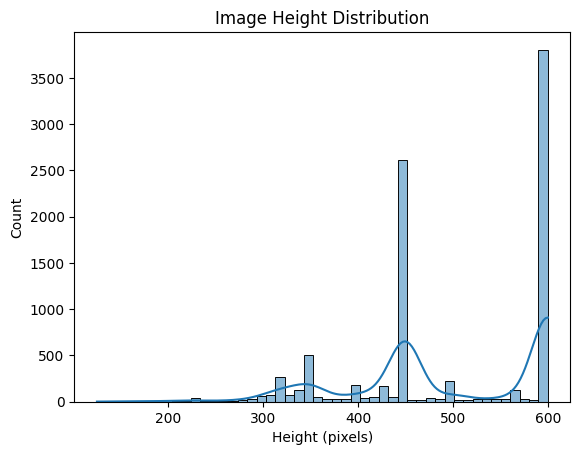

In [37]:
# Plotting Image heights

plt.figure()
sns.histplot(data = image_heights, kde= True, binwidth=10)
plt.title("Image Height Distribution")

plt.xlabel('Height (pixels)')
plt.show()

# Looks like we have two peaks, one around 450 and one around 600.
# We will opt for the smaller size, so 450.

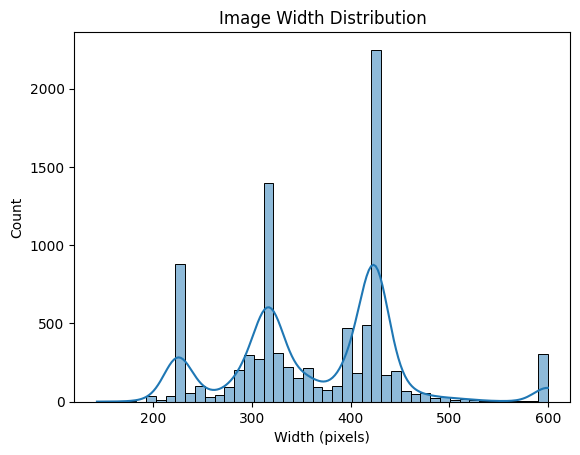

In [38]:
# Plotting Image widths

plt.figure()
sns.histplot(data = image_widths, kde= True, binwidth=10)
plt.title("Image Width Distribution")

plt.xlabel("Width (pixels)")
plt.show()

# This time it appears that we have three peaks: ~230, ~320, and ~430.
# We generally prefer shrinking images instead of enlarging them so we don't introduce artificial data into our images so we can choose between 230 and 320.

As we can see in the above visualizations, it appears out best bet for resize height and width of the images going into our CNN is height = 450 and width = 230/320 (we can try both and see which one performs the best).

In [39]:
resize_height = 450
resize_width = 320

### Dimensionality Reduction

Exploring the utility of using PCA for reducing the number of dimensions in our dataset (since we are only looking for predictive power and not necessarily interpretability).

In [40]:
# First we need to separate our data into a training set and a holdout set

# We want to keep the large majority of our data for training so we will use a 20% holdout ratio

holdout_ratio = 0.20
holdout_cutoff = int(len(anime_data) / holdout_ratio)
holdout_cutoff

9335

In [41]:
# Choose a ratio for the holdout set

holdout_ratio = 0.20
holdout_size = int(anime_data.shape[0] * holdout_ratio)

print(f"Holdout Ratio: {int(holdout_ratio*100)}%\nHoldout Size: {holdout_size} rows")

Holdout Ratio: 20%
Holdout Size: 373 rows


In [42]:
# Shuffle anime_data and divide the dataset (we need to shuffle since the current scores are stored in descending order)

y = anime_data['Score']
X = anime_data.drop(['Score', 'Blurb'], axis = 1)

X_train_tabular, X_holdout_tabular, y_train_tabular, y_holdout_tabular = train_test_split(X, y, test_size = holdout_ratio, random_state = 101, shuffle = True)

In [43]:
# Displaying the size of our training and holdout data

print(f"X_train_tabular : {X_train_tabular.shape}")
print(f"X_holdout_tabular : {X_holdout_tabular.shape}")
print(f"y_train_tabular : {y_train_tabular.shape}")
print(f"y_holdout_tabular : {y_holdout_tabular.shape}")

X_train_tabular : (1493, 1127)
X_holdout_tabular : (374, 1127)
y_train_tabular : (1493,)
y_holdout_tabular : (374,)


In [44]:
# Identifying the number of principal components we want to use for dimensionality reduction

X_train_names = X_train_tabular['Name']
X_train_tabular = X_train_tabular.drop('Name', axis = 1)

pca = PCA(random_state = 101)
pca.fit(X_train_tabular)
pca.explained_variance_ratio_.cumsum()

# Identified thresholds:
  # 2 PCs : 99.9% explained variance
  # 13 PCs : 99.95% explained variance
  # 172 PCs : 99.99% explained variance

# It looks like 13 principal components is a solid number to project on to keep the large majority of explained variance in our dataset!

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


array([0.81702485, 0.99901726, 0.99910264, ..., 1.        , 1.        ,
       1.        ])

In [45]:
# If you want to see the cumulative explained variance per PC please uncomment and run this cell

# for i,var in enumerate(pca.explained_variance_ratio_.cumsum()):
#   print(f"{i} : {var}")

In [46]:
# Projecting our data down to 8 principal components

components = 13
pca = PCA(n_components = components, random_state = 101)

X_train_tabular_pca = pd.DataFrame(pca.fit_transform(X_train_tabular))
X_train_tabular_pca

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-27.360274,93.305583,0.799543,-0.050949,-0.259819,0.236784,1.075902,0.575358,-0.159813,-0.340983,0.101779,-0.416544,0.330579
1,-6.349500,-16.248745,0.727690,-0.006847,-0.524393,0.923833,-0.592751,-0.134177,0.075220,-0.316122,-0.190318,-0.047719,0.199196
2,-16.126012,-19.146686,-1.074174,0.102842,-0.187110,0.919759,0.162006,-0.490050,0.122219,-0.109910,-0.278085,0.016277,0.052869
3,32.403077,-11.721786,0.737574,-0.107676,0.711047,-0.308419,-0.344909,0.758571,0.095642,-1.047890,-0.237706,0.405021,-0.370353
4,6.600499,-15.078874,-1.026469,-0.212256,-0.124616,-0.861198,0.057785,0.120204,0.878479,0.321733,-0.542019,-0.149304,-0.182466
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488,-15.401786,-38.155197,0.350703,-0.911644,0.022430,1.056547,0.225143,-0.118480,0.027517,-0.178560,-0.111407,0.155190,-0.158391
1489,-13.863637,-10.899774,1.107181,0.170804,0.316675,0.935129,1.061043,0.308985,0.541655,-0.413087,0.374789,0.294994,0.557665
1490,-17.210531,-18.248789,-0.495222,-0.294103,-0.461999,-0.695313,0.184570,-0.527053,0.048069,-0.111882,0.827978,-0.063750,-0.371536
1491,6.691305,-16.073892,-1.069925,0.118131,-0.200158,-0.143289,0.303976,-0.131772,-0.402666,-0.173283,-0.390405,0.203829,0.023810


In [47]:
# Renaming the columns, indexes, and adding the show names back

column_names = []

for i in range(X_train_tabular_pca.shape[1]):
  column_names.append('PC'+str(i))

X_train_tabular_pca.columns = column_names
X_train_tabular_pca.index = X_train_names.index
X_train_tabular_pca = pd.concat([X_train_names, X_train_tabular_pca], axis = 1)
X_train_tabular_pca.head(10)

,Name,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
814,Code Geass: Hangyaku no Lelouch I - Koudou,-27.360274,93.305583,0.799543,-0.050949,-0.259819,0.236784,1.075902,0.575358,-0.159813,-0.340983,0.101779,-0.416544,0.330579
1272,Kengan Ashura Part 2,-6.349500,-16.248745,0.727690,-0.006847,-0.524393,0.923833,-0.592751,-0.134177,0.075220,-0.316122,-0.190318,-0.047719,0.199196
910,Haikyuu!! Riku vs. Kuu,-16.126012,-19.146686,-1.074174,0.102842,-0.187110,0.919759,0.162006,-0.490050,0.122219,-0.109910,-0.278085,0.016277,0.052869
1366,Digimon Tamers,32.403077,-11.721786,0.737574,-0.107676,0.711047,-0.308419,-0.344909,0.758571,0.095642,-1.047890,-0.237706,0.405021,-0.370353
224,Bakuman. 2nd Season,6.600499,-15.078874,-1.026469,-0.212256,-0.124616,-0.861198,0.057785,0.120204,0.878479,0.321733,-0.542019,-0.149304,-0.182466
171,Saenai Heroine no Sodatekata Fine,-25.457929,72.385913,-0.268586,-0.984714,0.055339,-0.296488,-0.855059,0.750367,-0.118318,0.712050,-0.340265,-0.478939,0.354758
1261,Aishang Ta de Liyou,4.515363,-25.300338,0.209268,-1.064827,0.006316,0.304821,-0.196830,-0.664525,0.822625,0.473409,-0.115749,-0.040807,0.181009
597,Saiunkoku Monogatari 2nd Season,20.451850,-12.812280,0.320961,-0.566264,0.952253,-0.824670,-0.731685,-0.301682,-0.146882,-0.009575,-0.163804,0.132043,1.025647
74,Shigatsu wa Kimi no Uso,3.793285,-17.340685,-0.783042,-0.132682,-0.326286,-0.762991,0.147630,-0.589775,0.127840,0.711498,-0.461112,-0.110178,-0.106167
1156,Kyou kara Maou! 3rd Series,20.542932,-13.809126,0.197364,-0.477081,1.094690,-0.567346,-0.838933,0.429102,-0.161860,-0.186568,-0.028999,0.249677,0.053274


In [48]:
# Doing the same for the tabular holdout set

X_holdout_names = X_holdout_tabular['Name']
X_holdout_tabular = X_holdout_tabular.drop('Name', axis = 1)

X_holdout_tabular_pca = pd.DataFrame(pca.transform(X_holdout_tabular))
X_holdout_tabular_pca

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,-19.749848,9.657145,0.255346,0.686128,-0.011233,0.001788,0.112319,-0.492612,0.765522,-0.186570,1.290866,0.120298,-0.024352
1,-5.533253,-14.170626,1.219151,0.201539,-0.320029,-0.725403,-0.734138,-0.669166,0.009224,-0.173288,-0.543908,-0.158394,-0.330307
2,-6.254991,-17.254007,-1.179533,-0.015886,-0.164444,-0.506818,-0.149913,0.697506,0.246035,0.469957,-0.563052,-0.068869,0.190970
3,6.601341,-15.075676,-0.617854,0.552766,0.656204,-0.270070,-0.151360,-0.271289,-0.404323,-0.111061,-0.179289,0.992744,-0.041009
4,-6.257228,-17.250207,0.822542,-0.006450,-0.798974,-0.046378,-0.374202,1.062910,-0.049869,-0.264419,-0.416054,0.114970,-0.342777
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,-16.306877,-17.155261,-0.728270,-0.378119,-0.016765,0.465129,-0.268747,0.421927,0.326927,-0.129926,0.241051,-0.134905,-0.222829
370,-21.743219,31.566008,0.952058,0.112909,0.460694,0.398561,0.079997,0.031855,-0.103121,-0.763330,-0.211503,-0.533277,-0.250174
371,-7.250181,-17.340097,-0.941695,0.295143,0.404124,-0.248221,0.504852,0.706177,0.231901,-0.292509,-0.154811,0.868762,0.211486
372,3.793831,-17.338858,-0.174378,0.501998,0.211903,-0.245699,0.252030,0.161612,-0.383738,0.313585,1.278225,0.700681,0.203471


In [49]:
# Renaming the columns, indexes, and adding the show names back

column_names = []

for i in range(X_holdout_tabular_pca.shape[1]):
  column_names.append('PC'+str(i))

X_holdout_tabular_pca.columns = column_names
X_holdout_tabular_pca.index = X_holdout_names.index
X_holdout_tabular_pca = pd.concat([X_holdout_names, X_holdout_tabular_pca], axis = 1)
X_holdout_tabular_pca.head(10)

,Name,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
956,Lupin the IIIrd: Jigen Daisuke no Bohyou,-19.749848,9.657145,0.255346,0.686128,-0.011233,0.001788,0.112319,-0.492612,0.765522,-0.186570,1.290866,0.120298,-0.024352
236,Re:Zero kara Hajimeru Isekai Seikatsu 2nd Season,-5.533253,-14.170626,1.219151,0.201539,-0.320029,-0.725403,-0.734138,-0.669166,0.009224,-0.173288,-0.543908,-0.158394,-0.330307
1343,Kami nomi zo Shiru Sekai,-6.254991,-17.254007,-1.179533,-0.015886,-0.164444,-0.506818,-0.149913,0.697506,0.246035,0.469957,-0.563052,-0.068869,0.190970
1349,Pandora Hearts,6.601341,-15.075676,-0.617854,0.552766,0.656204,-0.270070,-0.151360,-0.271289,-0.404323,-0.111061,-0.179289,0.992744,-0.041009
626,Zombieland Saga Revenge,-6.257228,-17.250207,0.822542,-0.006450,-0.798974,-0.046378,-0.374202,1.062910,-0.049869,-0.264419,-0.416054,0.114970,-0.342777
122,Koukaku Kidoutai: Stand Alone Complex 2nd GIG,7.504460,-13.987055,0.536872,1.126950,-0.923916,-0.024543,0.567863,0.338207,-0.115105,0.047942,0.907386,-0.051967,0.488295
552,Kamisama Hajimemashita OVA,-15.400706,-27.112976,-0.719545,-0.320458,0.626419,0.213473,-0.728893,0.172225,0.983203,0.073510,0.050253,-0.540962,0.309578
459,Katekyou Hitman Reborn!,183.868748,1.049672,-0.827680,0.328530,0.087607,-0.029187,0.431577,0.606069,-0.051992,0.248534,-0.208601,-0.402792,-0.355395
1219,Chi's Sweet Home: Atarashii Ouchi,87.177219,-28.831800,-0.218506,0.101543,-0.673232,-0.153923,-0.491241,0.625258,0.384603,-0.939598,0.740210,-0.278887,-0.104168
1336,Evangelion Movie 3: Q,-23.737220,53.475291,0.742465,-0.571660,-0.150708,-0.020466,1.253046,-0.187067,0.339736,0.273690,0.072397,0.024005,-0.412328


In [50]:
# Displaying the shapes of our data again after dimensionality reduction

print(f"X_train_tabular_pca : {X_train_tabular_pca.shape}")
print(f"X_holdout_tabular_pca : {X_holdout_tabular_pca.shape}")
print(f"y_train_tabular : {y_train_tabular.shape}")
print(f"y_holdout_tabular : {y_holdout_tabular.shape}")

# We went from 89 columns to 9 columns! ('Name' will be dropped again before training the tabular models after compiling the training image set)

X_train_tabular_pca : (1493, 14)
X_holdout_tabular_pca : (374, 14)
y_train_tabular : (1493,)
y_holdout_tabular : (374,)


### Image Training Data

Now that we have identified the shows/movies present in our training set and holdout set, we need to load the images.

In [51]:
# Step 1: Given anime names, return a list of file paths to get those images as well as the scores
# function() -> (image filepath array, raw score array)

# input1: anime names
# input2: DataFrame to find indexes and scores (image_data)

def getImageFilePaths(X_tabular, image_data):

    image_filepaths = []
    image_rawScores = []

    for name in X_tabular['Name']:

        # Identify the records in image_data that correspond to that anime name
        image_data_records = image_data[image_data['AnimeName'] == name]

        # Identify the list of indexes (to make the file names)
        image_indexes = list(image_data_records.index)

        # Add the file names to image_filepaths
        image_filepaths.extend([("AnimeImagesZip/" + str(index)+".jpg") for index in image_indexes])

        # Identify the scores that correspond to each index
        image_scores = list(image_data_records['ImageScore'])

        # Add the scores as well
        image_rawScores.extend(image_scores)

    # Return the two arrays
    return (image_filepaths, image_rawScores)

In [52]:
# Collecting the training images and scores for X_train
(image_filepaths_train, image_rawScores_train) = getImageFilePaths(X_train_tabular_pca, image_data)

# The images for X_holdout will be collected, processed, and utilized directly during the multi-modal stacking process later on.

In [53]:
# Optional inspecting the first few rows

print(f"image_filepaths_train:\n{image_filepaths_train[:10]}")
print(f"\nimage_rawScores_train:\n{image_rawScores_train[:10]}")

image_filepaths_train:
['AnimeImagesZip/4425.jpg', 'AnimeImagesZip/4426.jpg', 'AnimeImagesZip/6564.jpg', 'AnimeImagesZip/6565.jpg', 'AnimeImagesZip/4883.jpg', 'AnimeImagesZip/4884.jpg', 'AnimeImagesZip/6933.jpg', 'AnimeImagesZip/6934.jpg', 'AnimeImagesZip/6935.jpg', 'AnimeImagesZip/6936.jpg']

image_rawScores_train:
[7.88, 7.88, 7.68, 7.68, 7.83, 7.83, 7.64, 7.64, 7.64, 7.64]


In [54]:
# Step 2: Given the list of file paths and the scores, perform image download, preprocessing, and return scores as well

# function() -> (image array , score array)

# def getImageData(image_filepaths, image_scores, resize_height, resize_width):

#     X = []
#     y = []

#     for i in range(len(image_filepaths)):
#         try:
#             resized_image_data = np.asarray(Image.open(image_filepaths[i]).resize((resize_height,resize_width)))
#         except:
#             continue
#         else:
#             X.append(resized_image_data)
#             y.append(image_scores[i])

#     # Converting to numpy arrays
#     X = np.asarray(X, dtype = "float32")
#     y = np.asarray(y, dtype = "float32")

#     return (X, y)

In [55]:
# Using getImageData() to generate training data for our CNN
# Takes ~ 1 minute to run

# (X_train_images, y_train_images) = getImageData(image_filepaths_train , image_rawScores_train , resize_height, resize_width)

In [56]:
# Displaying the shapes of the training and holdout sets

# print(f"X_train_images shape: {X_train_images.shape}")
# print(f"y_holdout_images shape: {y_train_images.shape}")

In [57]:
# Unfortunately the above code sections did not work in Google Colab because there is not enough RAM to store the images

# The below code was provided by ChatGPT on March 30th, 2024 to rectify this issue
class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, scores, target_size, batch_size, validation_split=0.2):
        self.image_paths = image_paths
        self.scores = scores
        self.target_size = target_size
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.train_indexes, self.validation_indexes = self._split_data()

    def _split_data(self):
        num_samples = len(self.image_paths)
        split_index = int((1 - self.validation_split) * num_samples)
        indexes = np.arange(num_samples)
        np.random.shuffle(indexes)
        train_indexes = indexes[:split_index]
        validation_indexes = indexes[split_index:]
        return train_indexes, validation_indexes

    def __len__(self):
        return int(np.ceil(len(self.train_indexes) / self.batch_size))

    def __getitem__(self, index):
        start_index = index * self.batch_size
        end_index = min((index + 1) * self.batch_size, len(self.train_indexes))
        batch_indexes = self.train_indexes[start_index:end_index]
        batch_images = []
        batch_scores = []
        for idx in batch_indexes:
            # Load image from file path
            image = load_img(self.image_paths[idx], target_size=self.target_size)
            image_array = img_to_array(image) / 255.0  # Normalize pixel values
            batch_images.append(image_array)
            # Extract score
            batch_scores.append(self.scores[idx])
        return np.array(batch_images), np.array(batch_scores)

    def get_validation_data(self):
        batch_images = []
        batch_scores = []
        for idx in self.validation_indexes:
            # Load image from file path
            image = load_img(self.image_paths[idx], target_size=self.target_size)
            image_array = img_to_array(image) / 255.0  # Normalize pixel values
            batch_images.append(image_array)
            # Extract score
            batch_scores.append(self.scores[idx])
        return np.array(batch_images), np.array(batch_scores)

In [58]:
# The template for this code was also provided by ChatGPT

# Define parameters
image_paths = image_filepaths_train
scores = image_rawScores_train
target_size = (resize_height, resize_width)
batch_size = 32
validation_split = 0.2

# Create custom data generator
train_generator = CustomDataGenerator(image_paths, scores, target_size, batch_size, validation_split)

# Train the model using fit() with validation data
validation_data = train_generator.get_validation_data()

## Finding the Best Model for Tabular Data

Since we are performing a supervised regression task (predicting continuous scores), we will be evaluating the performance of a few different regression models and choosing the best one based on minimizing the Root Mean Squared Error (or average RMSE when using cross-validation).

In [59]:
# Models we are going to try on our PCA reduced dataset
  # Linear Regression
  # Random Forest Regression
  # Gradient Boosted Trees

# The model with the lowest RMSE will be the winner
models = []
params = []
rmse_list = []

In [60]:
# Linear Regression

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X_train_tabular_pca = X_train_tabular_pca.drop('Name', axis = 1, errors = 'ignore')

linear_model = LinearRegression()
linear_model.fit(X_train_tabular_pca, y_train_tabular)

# Calculating the RMSE
y_preds = linear_model.predict(X_train_tabular_pca)
rmse = mean_squared_error(y_train_tabular, y_preds) ** 0.5

# Appending to lists and printing results
models.append("Linear Regression")
params.append("Default")
rmse_list.append(rmse)

print(f"Model : {linear_model}\nRMSE : {rmse}")

Model : LinearRegression()
RMSE : 0.3204135507197627


In [61]:
# ElasticNet (Linear Regression with Regularization)

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

param_grid = {'l1_ratio' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]}

elasticNetModels = GridSearchCV(estimator = ElasticNet(random_state = 101, max_iter=10000000),
                                param_grid = param_grid,
                                scoring = 'neg_root_mean_squared_error',
                                verbose = 1)

elasticNetModels.fit(X_train_tabular_pca, y_train_tabular)

# Adding the results to our lists
num_estimators = len(elasticNetModels.cv_results_['params'])
elasticNet_scores = elasticNetModels.cv_results_['mean_test_score'] * -1.00
elasticNet_params = [str(param) for param in elasticNetModels.cv_results_['params']]

models.extend(['ElasticNet'] * num_estimators)
rmse_list.extend(elasticNet_scores)
params.extend(elasticNet_params)

clear_output()
print(f"Best Model : {str(elasticNetModels.best_estimator_)}\nBest RMSE : {elasticNetModels.best_score_ * -1.00}")

Best Model : ElasticNet(l1_ratio=1e-05, max_iter=10000000, random_state=101)
Best RMSE : 0.33202787644971893


In [62]:
# Random Forest Regression

from sklearn.ensemble import RandomForestRegressor

param_grid = {'max_depth' : [3, 4, 5, 6, None]}

randomForestModels = GridSearchCV(estimator = RandomForestRegressor(random_state = 101, n_estimators = 100, criterion = 'squared_error'),
                                param_grid = param_grid,
                                scoring = 'neg_root_mean_squared_error',
                                verbose = 1)

randomForestModels.fit(X_train_tabular_pca, y_train_tabular)

# Adding the results to our lists
num_estimators = len(randomForestModels.cv_results_['params'])
randomForest_scores = randomForestModels.cv_results_['mean_test_score'] * -1.00
randomForest_params = [str(param) for param in randomForestModels.cv_results_['params']]

models.extend(['RandomForestRegressor'] * num_estimators)
rmse_list.extend(randomForest_scores)
params.extend(randomForest_params)

clear_output()
print(f"Best Model : {str(randomForestModels.best_estimator_)}\nBest RMSE : {randomForestModels.best_score_ * -1.00}")

Best Model : RandomForestRegressor(random_state=101)
Best RMSE : 0.30277286066438885


In [63]:
# GradientBoostingRegressor

from sklearn.ensemble import GradientBoostingRegressor

param_grid = {'criterion' : ['friedman_mse', 'squared_error'],
              'max_depth' : [3, 4, 5, 6, None]}

gradBoostModels = GridSearchCV(estimator = GradientBoostingRegressor(random_state = 101),
                                param_grid = param_grid,
                                scoring = 'neg_root_mean_squared_error',
                                verbose = 1)
gradBoostModels.fit(X_train_tabular_pca, y_train_tabular)

# Adding the results to our lists
num_estimators = len(gradBoostModels.cv_results_['params'])
gradBoost_scores = gradBoostModels.cv_results_['mean_test_score'] * -1.00
gradBoost_params = [str(param) for param in gradBoostModels.cv_results_['params']]

models.extend(['GradientBoostingRegressor'] * num_estimators)
rmse_list.extend(gradBoost_scores)
params.extend(gradBoost_params)

clear_output()
print(f"Best Model : {str(gradBoostModels.best_estimator_)}\nBest RMSE : {gradBoostModels.best_score_ * -1.00}")

Best Model : GradientBoostingRegressor(criterion='squared_error', max_depth=4,
                          random_state=101)
Best RMSE : 0.3057855630697605


In [64]:
# AdaBoost

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

param_grid = {'estimator' : [DecisionTreeRegressor(max_depth=3, random_state=101),
                             DecisionTreeRegressor(max_depth=4, random_state=101),
                             DecisionTreeRegressor(max_depth=5, random_state=101),
                             DecisionTreeRegressor(max_depth=6, random_state=101),
                             DecisionTreeRegressor(max_depth=None, random_state=101)]
              }

adaBoostModels = GridSearchCV(estimator = AdaBoostRegressor(random_state = 101),
                                param_grid = param_grid,
                                scoring = 'neg_root_mean_squared_error',
                                verbose = 1)
adaBoostModels.fit(X_train_tabular_pca, y_train_tabular)

# Adding the results to our lists
num_estimators = len(adaBoostModels.cv_results_['params'])
adaBoost_scores = adaBoostModels.cv_results_['mean_test_score'] * -1.00
adaBoost_params = [str(param) for param in adaBoostModels.cv_results_['params']]

models.extend(['AdaBoostRegressor'] * num_estimators)
rmse_list.extend(adaBoost_scores)
params.extend(adaBoost_params)

clear_output()
print(f"Best Model : {str(adaBoostModels.best_estimator_)}\nBest RMSE : {adaBoostModels.best_score_ * -1.00}")

Best Model : AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=6,
                                                  random_state=101),
                  random_state=101)
Best RMSE : 0.3102636190637356


In [65]:
# Compiling and Displaying the final results in a DataFrame

tabular_model_results = pd.DataFrame()
tabular_model_results['Model'] = models
tabular_model_results['Params'] = params
tabular_model_results['RMSE'] = rmse_list

tabular_model_results = tabular_model_results.sort_values(by='RMSE')
tabular_model_results

,Model,Params,RMSE
15,RandomForestRegressor,{'max_depth': None},0.302773
22,GradientBoostingRegressor,"{'criterion': 'squared_error', 'max_depth': 4}",0.305786
17,GradientBoostingRegressor,"{'criterion': 'friedman_mse', 'max_depth': 4}",0.305786
19,GradientBoostingRegressor,"{'criterion': 'friedman_mse', 'max_depth': 6}",0.306476
24,GradientBoostingRegressor,"{'criterion': 'squared_error', 'max_depth': 6}",0.306479
23,GradientBoostingRegressor,"{'criterion': 'squared_error', 'max_depth': 5}",0.306578
18,GradientBoostingRegressor,"{'criterion': 'friedman_mse', 'max_depth': 5}",0.306578
14,RandomForestRegressor,{'max_depth': 6},0.308593
21,GradientBoostingRegressor,"{'criterion': 'squared_error', 'max_depth': 3}",0.308688
16,GradientBoostingRegressor,"{'criterion': 'friedman_mse', 'max_depth': 3}",0.308688


In [66]:
# Reporting our best model trained on tabular data

best_tabular_model_report = tabular_model_results.iloc[0]
print(f"Overall best model for tabular data : {best_tabular_model_report['Model']}")
print(f"Best performing parameters : {best_tabular_model_report['Params']}")
print(f"Lowest RMSE achieved by model : {best_tabular_model_report['RMSE']}")

Overall best model for tabular data : RandomForestRegressor
Best performing parameters : {'max_depth': None}
Lowest RMSE achieved by model : 0.30277286066438885


In [67]:
# Re-training the best model on the training data to use later

best_tabular_model = RandomForestRegressor(random_state = 101, n_estimators = 100, criterion = 'squared_error', max_depth = None)
best_tabular_model.fit(X_train_tabular_pca, y_train_tabular)

RandomForestRegressor(random_state=101)

## Finding the Best Model for Image Data (CNN)

In [68]:
# Convolutional Block

# Architecture: Convolutional Layer -> Batch Normalization -> Activation Function -> Max Pooling -> Dropout

def ConvolutionalBlock(filters, kernel_size, activation = 'relu', dropout_ratio = 0.5, strides = (1,1)):

  model_block = Sequential()

  model_block.add(Conv2D(filters = filters, kernel_size = kernel_size, strides =  strides, padding = 'valid'))
  model_block.add(BatchNormalization(axis=-1, trainable=True))
  model_block.add(Activation(activation=activation))
  model_block.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid'))
  model_block.add(Dropout(rate = dropout_ratio))

  return model_block

In [69]:
# Dense Block

# Architecture: Dense Layer -> Batch Normalization -> Activation Function -> Dropout

def DenseBlock(units = 32, activation = 'relu', dropout_ratio = 0.25):

  model_block = Sequential()

  model_block.add(Dense(units = units))
  model_block.add(BatchNormalization(axis = -1, trainable = True))
  model_block.add(Activation(activation = activation))
  model_block.add(Dropout(rate = dropout_ratio))

  return model_block

In [70]:
# Compiling desired network

# cnn = Sequential()

# cnn.add(ConvolutionalBlock(filters = 32, kernel_size = (3,3)))
# cnn.add(Flatten())
# cnn.add(DenseBlock(units = 128))
# cnn.add(Dense(1, activation = 'linear'))

# cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Epoch 1/10
# 181/181 [==============================] - 61s 308ms/step - loss: 40.4098 - mean_squared_error: 40.4098 - val_loss: 21.2787 - val_mean_squared_error: 21.2787
# Epoch 2/10
# 181/181 [==============================] - 59s 324ms/step - loss: 10.6923 - mean_squared_error: 10.6923 - val_loss: 4.2171 - val_mean_squared_error: 4.2171
# Epoch 3/10
# 181/181 [==============================] - 55s 305ms/step - loss: 3.7405 - mean_squared_error: 3.7405 - val_loss: 3.2605 - val_mean_squared_error: 3.2605
# Epoch 4/10
# 181/181 [==============================] - 67s 369ms/step - loss: 2.9721 - mean_squared_error: 2.9721 - val_loss: 1.3346 - val_mean_squared_error: 1.3346
# Epoch 5/10
# 181/181 [==============================] - 52s 287ms/step - loss: 2.7772 - mean_squared_error: 2.7772 - val_loss: 1.7874 - val_mean_squared_error: 1.7874
# Epoch 6/10
# 181/181 [==============================] - 61s 338ms/step - loss: 2.5901 - mean_squared_error: 2.5901 - val_loss: 1.0721 - val_mean_squared_error: 1.0721
# Epoch 7/10
# 181/181 [==============================] - 52s 287ms/step - loss: 2.3920 - mean_squared_error: 2.3920 - val_loss: 0.8669 - val_mean_squared_error: 0.8669
# Epoch 8/10
# 181/181 [==============================] - 55s 302ms/step - loss: 2.3017 - mean_squared_error: 2.3017 - val_loss: 1.0198 - val_mean_squared_error: 1.0198
# Epoch 9/10
# 181/181 [==============================] - 48s 264ms/step - loss: 2.2128 - mean_squared_error: 2.2128 - val_loss: 1.1798 - val_mean_squared_error: 1.1798

In [71]:
# Trying another architecture

cnn = Sequential()

# Convolutional Blocks
cnn.add(ConvolutionalBlock(filters = 32, kernel_size = (3,3), dropout_ratio = 0.5))
cnn.add(ConvolutionalBlock(filters = 64, kernel_size = (3,3), dropout_ratio = 0.25))
cnn.add(Flatten())

# Dense Blocks
cnn.add(DenseBlock(units = 256, dropout_ratio = 0.5))
cnn.add(DenseBlock(units = 128, dropout_ratio = 0.25))

# Output
cnn.add(Dense(1, activation='linear'))

cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Epoch 1/10
# 181/181 [==============================] - 147s 780ms/step - loss: 23.1822 - mean_squared_error: 23.1822 - val_loss: 2.1998 - val_mean_squared_error: 2.1998
# Epoch 2/10
# 181/181 [==============================] - 170s 943ms/step - loss: 1.3785 - mean_squared_error: 1.3785 - val_loss: 0.4833 - val_mean_squared_error: 0.4833
# Epoch 3/10
# 181/181 [==============================] - 73s 403ms/step - loss: 1.2976 - mean_squared_error: 1.2976 - val_loss: 1.6116 - val_mean_squared_error: 1.6116
# Epoch 4/10
# 181/181 [==============================] - 74s 409ms/step - loss: 1.1495 - mean_squared_error: 1.1495 - val_loss: 0.9302 - val_mean_squared_error: 0.9302

In [72]:
# Third architecture

# cnn = Sequential()

# cnn.add(ConvolutionalBlock(filters = 32, kernel_size = (3,3)))
# cnn.add(ConvolutionalBlock(filters = 64, kernel_size = (3,3), dropout_ratio = 0.25))

# cnn.add(Flatten())

# cnn.add(DenseBlock(units = 128))
# cnn.add(Dense(1, activation = 'linear'))

# cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# Epoch 1/10
# 181/181 [==============================] - 100s 505ms/step - loss: 21.7585 - mean_squared_error: 21.7585 - val_loss: 1.9569 - val_mean_squared_error: 1.9569
# Epoch 2/10
# 181/181 [==============================] - 85s 467ms/step - loss: 1.7598 - mean_squared_error: 1.7598 - val_loss: 1.8129 - val_mean_squared_error: 1.8129
# Epoch 3/10
# 181/181 [==============================] - 92s 510ms/step - loss: 1.3805 - mean_squared_error: 1.3805 - val_loss: 0.6446 - val_mean_squared_error: 0.6446
# Epoch 4/10
# 181/181 [==============================] - 72s 398ms/step - loss: 1.3023 - mean_squared_error: 1.3023 - val_loss: 2.4564 - val_mean_squared_error: 2.4564
# Epoch 5/10
# 181/181 [==============================] - 70s 387ms/step - loss: 1.0951 - mean_squared_error: 1.0951 - val_loss: 1.2094 - val_mean_squared_error: 1.2094

In [73]:
# Training

# Early Stopping
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 3, min_delta = 0.01)

# Model Checkpoint
checkpoint_filepath = './ModelCheckpoints'
model_checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_filepath,
    monitor = 'val_mean_squared_error',
    mode = 'min',
    save_best_only = True
)

# Creating the Model Checkpoint folder if it does not exist already
if 'ModelCheckpoints' not in os.listdir():
  os.makedirs('ModelCheckpoints')

# Training the model
epochs = 15

history = cnn.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=epochs,
    validation_data=validation_data,
    callbacks = [es, model_checkpoint_callback]
)

Epoch 1/15
181/181 [==============================] - 110s 560ms/step - loss: 23.1448 - mean_squared_error: 23.1448 - val_loss: 0.8167 - val_mean_squared_error: 0.8167
Epoch 2/15
181/181 [==============================] - 72s 396ms/step - loss: 1.4464 - mean_squared_error: 1.4464 - val_loss: 1.5759 - val_mean_squared_error: 1.5759
Epoch 3/15
181/181 [==============================] - 72s 398ms/step - loss: 1.2292 - mean_squared_error: 1.2292 - val_loss: 1.1894 - val_mean_squared_error: 1.1894
Epoch 4/15
181/181 [==============================] - 74s 411ms/step - loss: 1.1375 - mean_squared_error: 1.1375 - val_loss: 1.0721 - val_mean_squared_error: 1.0721


In [74]:
# To load the best model
best_cnn = load_model('ModelCheckpoints')

## Stacking Predictions to Improve Performance

Now that we have successfully found our best performing ML model for the tabular data as well as a fine-tuned CNN for the respective images, it is time to form our multi-modal approach.

In [75]:
# Create a new dataFrame of tabular predictions, avg(image predictions), real scores, and combine using linear regression (report the R-squared and RMSE)

# Returns a dataframe of tabular predictions and average image predictions per show/movie
def stackPredictions(X_tabular, X_names, y_tabular, best_tabular_model, image_data, resize_height, resize_width, best_cnn_model, tabular_coefficient = 1.0, cnn_coefficient = 1.0):

  tabular_predictions = []
  scores = []
  cnn_predictions = []

  indexes = X_tabular.index

  for index in indexes:

    # Make a prediction based on the best tabular model
    tabular_prediction = best_tabular_model.predict([X_tabular.loc[index]])[0]
    tabular_prediction = tabular_prediction * tabular_coefficient # Using these coefficients so we can repurpose for the holdout evaluation
    tabular_predictions.append(tabular_prediction)

    # Find the corresponding score (target)
    score = y_tabular.loc[index]
    scores.append(score)

    # Making the image predictions
    anime_name = X_names.loc[index]
    image_indexes = list(image_data[image_data['AnimeName'] == anime_name].index)
    image_filepaths = ["AnimeImagesZip/"+str(idx)+".jpg" for idx in image_indexes]

    image_predictions = []
    for path in image_filepaths:
      image = load_img(path, target_size=(resize_height, resize_width))
      image_array = img_to_array(image) / 255.0
      image_array = np.expand_dims(image_array, axis=0)
      cnn_pred = best_cnn.predict(image_array)[0][0]
      image_predictions.append(cnn_pred)

    if len(image_predictions) == 0:
      print(f"No images to match loc: {index}")
      cnn_predictions.append(-1.00)
    else:
      avg_cnn_prediction = np.mean(image_predictions) # Averaging the scores of all images for the same show
      final_cnn_prediction = avg_cnn_prediction * cnn_coefficient
      cnn_predictions.append(final_cnn_prediction)

  # Combining everything into a DataFrame and returning
  stackedPredictions = pd.DataFrame()
  stackedPredictions['TabularPreds'] = tabular_predictions
  stackedPredictions['CnnPreds'] = cnn_predictions
  stackedPredictions['Scores'] = scores

  clear_output()
  return stackedPredictions

In [76]:
# Calling our new stacking method
# Takes roughly 15 minutes

stackedPredictions_train = stackPredictions(X_train_tabular_pca, X_train_names, y_train_tabular, best_tabular_model, image_data, resize_height, resize_width, best_cnn)

In [77]:
# Displaying the stacked predictions

stackedPredictions_train

,TabularPreds,CnnPreds,Scores
0,7.9275,6.285417,7.88
1,7.7362,6.338109,7.68
2,7.8093,7.486849,7.83
3,7.7045,7.435984,7.64
4,8.3120,7.631964,8.34
...,...,...,...
1488,7.6150,7.955659,7.57
1489,7.6216,7.603374,7.50
1490,7.8140,6.330192,7.63
1491,7.7324,7.706831,7.58


In [78]:
# Finding the ideal coefficients for both prediction types

# Separate into X and y and train a LinearRegression Model to find coefficients
stack_y_train = stackedPredictions_train['Scores']
stack_X_train = stackedPredictions_train.drop('Scores', axis = 1)

# Using Linear Regression to generate coefficients
stack_linear_model = LinearRegression()
stack_linear_model.fit(stack_X_train, stack_y_train)

# Reporting the coefficients and other metrics
print(f"Features: {stack_linear_model.feature_names_in_}")
print(f"Coefficients: {stack_linear_model.coef_}")
print(f"Intercept: {stack_linear_model.intercept_}")

Features: ['TabularPreds' 'CnnPreds']
Coefficients: [1.30079739 0.00962067]
Intercept: -2.456047772380569


In [79]:
# Also report the R-squared and RMSE of the stacked model

from sklearn.metrics import r2_score

stack_y_preds = stack_linear_model.predict(stack_X_train)

stack_r2 = r2_score(stack_y_train, stack_y_preds)
stack_rmse = mean_squared_error(stack_y_train, stack_y_preds) ** 0.5

print(f"Stacked Model R-Squared : {round(stack_r2*100,2)}%")
print(f"Stacked Model RMSE : {round(stack_rmse,4)}")

Stacked Model R-Squared : 93.74%
Stacked Model RMSE : 0.0845


In [80]:
# Once you find the coefficients set them equal to tabular_coefficient and cnn_coefficient respectively

tabular_coefficient = stack_linear_model.coef_[0]
cnn_coefficient = stack_linear_model.coef_[1]

## Evaluating the Multi-Model Approach and Next Steps

Now that we have found the ideal coefficients (and intercept) to create our stacked predictions, we will apply them to the holdout data and evaluate the overall performance of the approach.

In [81]:
# Making the predictions on our holdout data

X_holdout_names = X_holdout_tabular_pca['Name']
X_holdout_tabular_pca = X_holdout_tabular_pca.drop('Name', axis = 1)

In [82]:
stackedPredictions_test = stackPredictions(X_holdout_tabular_pca, X_holdout_names, y_holdout_tabular, best_tabular_model, image_data, resize_height, resize_width, best_cnn,
                                           tabular_coefficient = tabular_coefficient, cnn_coefficient = cnn_coefficient)

In [83]:
# Making the final predictions by adding the two scores and the intercept for each row

stackedPredictions_test['StackedPredictions'] = stackedPredictions_test['TabularPreds'] + stackedPredictions_test['CnnPreds']
stackedPredictions_test['StackedPredictions'] = stackedPredictions_test['StackedPredictions'] + stack_linear_model.intercept_

stackedPredictions_test.head(20)

,TabularPreds,CnnPreds,Scores,StackedPredictions
0,10.272137,0.071126,7.81,7.887215
1,10.806244,0.069135,8.33,8.419332
2,10.205016,0.071433,7.65,7.820401
3,10.232983,0.072683,7.65,7.849618
4,10.041636,0.072607,8.00,7.658195
5,10.570930,0.069401,8.52,8.184283
6,10.369827,0.076601,8.05,7.990380
7,10.483907,0.069913,8.13,8.097772
8,10.095619,0.077151,7.70,7.716722
9,10.189276,0.071803,7.65,7.805031


In [84]:
# Reporting the R-squared and RMSE of the stackedPredictions (on holdout set)

holdout_y_preds = stackedPredictions_test['StackedPredictions']

holdout_r2 = r2_score(stackedPredictions_test['Scores'], holdout_y_preds)
holdout_rmse = mean_squared_error(stackedPredictions_test['Scores'], holdout_y_preds) ** 0.5

print(f"Stacked Model R-Squared : {round(holdout_r2*100,2)}%")
print(f"Stacked Model RMSE : {round(holdout_rmse,4)}")

Stacked Model R-Squared : 21.45%
Stacked Model RMSE : 0.307


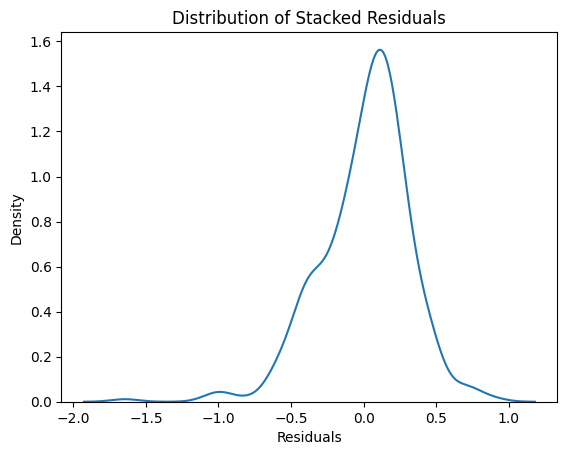

In [85]:
# Visualizing the distribution of residuals

holdout_resids = holdout_y_preds - stackedPredictions_test['Scores']

plt.figure()

sns.kdeplot(holdout_resids)
plt.title("Distribution of Stacked Residuals")

plt.xlabel("Residuals")

plt.show()

In [86]:
# Reporting descriptive statistics about these residuals

stats.describe(holdout_resids)

# Skew : -0.82 (slightly left skewed but still normal)
# Kurtosis: 2.54 (slightly outside the upper limit for normality)

DescribeResult(nobs=374, minmax=(-1.644708584745696, 0.8968695558937982), mean=0.01002988534022147, variance=0.09440878848208892, skewness=-0.8185757379602322, kurtosis=2.543261536840223)

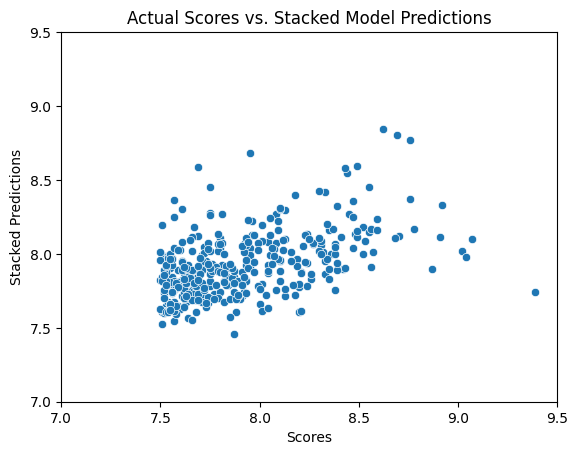

In [87]:
# Visualizing a scatterplot of Scores vs. Predictions

plt.figure()
sns.scatterplot(x = stackedPredictions_test['Scores'], y = stackedPredictions_test['StackedPredictions'])
plt.title("Actual Scores vs. Stacked Model Predictions")

plt.ylabel("Stacked Predictions")

plt.xlim(7.00, 9.50)
plt.ylim(7.00, 9.50)

plt.show()

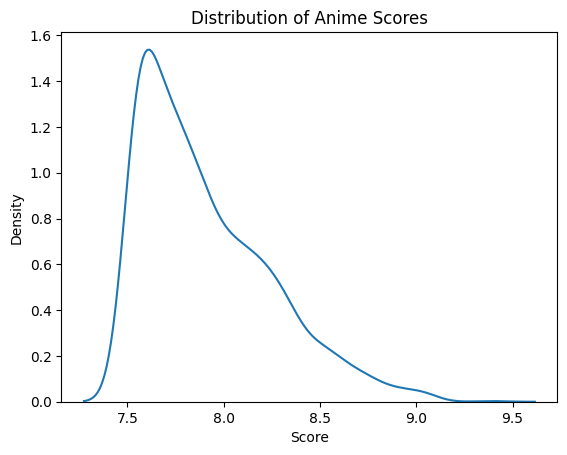

In [88]:
# Relating the outlier where Score > 9.00 to the quantity of records with those scores in our dataset

plt.figure()
sns.kdeplot(anime_data['Score'])
plt.title("Distribution of Anime Scores")

plt.show()